In [1]:
!pip install tqdm

from tqdm import tqdm
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
from PIL import Image
import tensorflow as tf

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [0]:
tf.set_random_seed(10)
np.random.seed(10)

In [3]:

df = pd.read_csv('https://github.com/harveenchadha/dump-nn-tf/raw/master/Section2/NN_Predict_Fraud/train.csv')
df.dropna(inplace=True)
iris = tf.contrib.learn.datasets.load_iris()

scl = StandardScaler()

Instructions for updating:
Use scikits.learn.datasets.
Instructions for updating:
Use tf.data instead.


In [0]:
def WeightsVariable(shape, num = 0):
    name = 'weights' + str(num)
    return tf.get_variable(name=name, initializer=tf.initializers.glorot_uniform(),shape=shape) #tf.nn tf.truncated_normal(shape, mean = 0.0, stddev=0.001, name=name))

def BiasVariable(shape, name = 'biases'):
    return tf.Variable(tf.constant(1.0, shape=[shape], name='biases'))

In [0]:
def network(images, channels = 1, input_shape = 4, output_shape = 3):
#     num_c = [256, 128, 64, 32, 16, 8, 4]
    num_i = 0
    with tf.name_scope('fc1'):
        weights = WeightsVariable([input_shape, num_c[num_i]], num = num_i)
        biases = BiasVariable(num_c[num_i])
        fc1 = tf.nn.relu(tf.matmul(images, weights) + biases)
    num_i += 1
    
    for i in range(len(num_c)-1):
        name = 'fc' + str(i+2)
        with tf.name_scope(name):
            weights = WeightsVariable([num_c[num_i - 1], num_c[num_i]], num = num_i)
            biases = BiasVariable(num_c[num_i])
            fc1 = tf.nn.relu(tf.matmul(fc1, weights) + biases)
        num_i += 1    

    with tf.name_scope('fc4'):
        weights = WeightsVariable([num_c[num_i - 1], output_shape], num = num_i)
        biases = BiasVariable(output_shape)
        fc2 = tf.matmul(fc1, weights) + biases
        
    return fc2

In [0]:
def loss_metrics(logits, labels, output_shape=1):
    logits = logits
    if output_shape == 1:
      cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, 
                                                                   logits = logits, 
                                                                   name = 'softmax')
      
    else:
      cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = labels, 
                                                                   logits = logits, 
                                                                   name = 'softmax')
    return tf.reduce_mean(cross_entropy, name = 'softmax_mean')

In [0]:
#returns the optimizer by taking the loss
def training(loss):
    global_step = tf.Variable(0, name = 'global_step', trainable = False)
    
    learning_rate = tf.train.exponential_decay(STARTER_LR, 
                                               global_step = global_step, 
                                               decay_steps = 200, 
                                               decay_rate = 0.6, 
                                               staircase = True)
    optimizer = tf.train.AdamOptimizer(learning_rate = STARTER_LR)
    train_op = optimizer.minimize(loss)
    return train_op
    

In [0]:
def evaluation(logits, labels, output_shape = 1):
    correct = tf.nn.in_top_k(logits, labels, k = 1)
    return tf.reduce_sum(tf.cast(correct, tf.int32))#, accuracy1, accuracy2
  
def acc(logits, labels, output_shape = 1):
  
    if(output_shape == 1):
        correct_prediction = tf.equal(tf.cast(tf.greater_equal(logits,0.5), tf.float32), tf.cast(labels, tf.float32))
        
    else:
        correct_prediction = tf.equal(tf.argmax(logits, 1),  tf.cast(labels, tf.int64), name='correct_pred')
    
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
    return accuracy

In [0]:
def placeholder_inputs(batch_size, input_shape=None, output_shape=1):
    image_placeholder = tf.placeholder(tf.float32, shape = (None, input_shape))
    if output_shape == 1:
      label_placeholder = tf.placeholder(tf.float32, shape = (None))
    else:
      label_placeholder = tf.placeholder(tf.int32, shape = (None))
    return image_placeholder, label_placeholder

In [0]:

loss_plot = []
acc_plot = []
train_plot = []
def run_training(x, y, input_shape=None, output_shape=1):
  
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
    with tf.Graph().as_default():

        images_pl, labels_pl = placeholder_inputs(BATCH_SIZE, input_shape=input_shape, output_shape = output_shape)
        logits = network(images_pl, input_shape=input_shape, output_shape=output_shape)
        
        print("Logits Calculated Successfully")
        loss = loss_metrics(logits = logits, labels = labels_pl, output_shape = output_shape)
        train_op = training(loss)
#         eval_correct = evaluation(logits, labels_pl)
        acc_val = acc(logits, labels_pl, output_shape = output_shape)
        summary = tf.summary.merge_all()
        
        init = tf.global_variables_initializer()
        
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9) #OPTIONAL
        sess = tf.Session(config=tf.ConfigProto(gpu_options = gpu_options))
        
        saver = tf.train.Saver()
        sess.run(init)
        for steps in range(MAX_STEPS):
            loss_avg = []
            for i in tqdm(np.arange(0, len(x_train), BATCH_SIZE)):
                images_feed = x_train[i : i + BATCH_SIZE]
                labels_feed = y_train[i : i + BATCH_SIZE]

                feed_dict = { images_pl: images_feed, labels_pl: labels_feed }

                _ = sess.run([train_op], feed_dict = feed_dict)
                

            images_feed = x_test
            labels_feed = y_test

            feed_dict = {
                images_pl: images_feed,
                labels_pl: labels_feed
                        }
            loss_  = sess.run([loss], feed_dict = feed_dict)
            accuracy_val  = sess.run([acc_val], feed_dict = feed_dict)
            images_feed = x_train
            labels_feed = y_train

            feed_dict = {
                images_pl: images_feed,
                labels_pl: labels_feed
                        }
            train_loss  = sess.run([loss], feed_dict = feed_dict)
            
            loss_plot.append(loss_)
            train_plot.append(train_loss)
            acc_plot.append(accuracy_val)
            print('Loss %d: Training loss = %.5f  Validation loss = %.5f\t Validation Acc = %.5f' % (steps+1, train_loss[0], loss_[0], accuracy_val[0]))     
          
        return sess, images_pl, labels_pl, acc_val, logits

In [22]:

x = iris[0]
y = iris[1]

x = df.iloc[:, :30]
y = df.iloc[:, -1:]


x = scl.fit_transform(x)

STARTER_LR = 45e-6
BATCH_SIZE = 4
MAX_STEPS = 15
num_c = [512, 256, 128, 64, 32]

loss_plot = []
acc_plot = []
train_plot = []
sess, images_pl, labels_pl, eval_correct, logits = run_training(np.asarray(x, dtype = np.float32), np.asarray(y, dtype = np.float32), 
                      
                                                                input_shape=x.shape[1], output_shape=1)

Logits Calculated Successfully


 29%|██▉       | 46/158 [00:00<00:00, 459.93it/s]

Loss 1: Training loss = 0.36510  Validation loss = 0.32306	 Validation Acc = 0.88889


 31%|███       | 49/158 [00:00<00:00, 483.46it/s]

Loss 2: Training loss = 0.25776  Validation loss = 0.22426	 Validation Acc = 0.92593


 32%|███▏      | 50/158 [00:00<00:00, 491.62it/s]

Loss 3: Training loss = 0.21512  Validation loss = 0.19265	 Validation Acc = 0.92222


 30%|███       | 48/158 [00:00<00:00, 473.81it/s]

Loss 4: Training loss = 0.19052  Validation loss = 0.17522	 Validation Acc = 0.92963


 32%|███▏      | 50/158 [00:00<00:00, 497.81it/s]

Loss 5: Training loss = 0.17223  Validation loss = 0.16523	 Validation Acc = 0.93333


 32%|███▏      | 50/158 [00:00<00:00, 494.30it/s]

Loss 6: Training loss = 0.15911  Validation loss = 0.15731	 Validation Acc = 0.93333


 32%|███▏      | 50/158 [00:00<00:00, 497.06it/s]

Loss 7: Training loss = 0.15005  Validation loss = 0.15270	 Validation Acc = 0.93704


 29%|██▉       | 46/158 [00:00<00:00, 456.18it/s]

Loss 8: Training loss = 0.14398  Validation loss = 0.15008	 Validation Acc = 0.94074


 30%|██▉       | 47/158 [00:00<00:00, 466.03it/s]

Loss 9: Training loss = 0.13824  Validation loss = 0.14804	 Validation Acc = 0.94444


 32%|███▏      | 50/158 [00:00<00:00, 491.71it/s]

Loss 10: Training loss = 0.13505  Validation loss = 0.14611	 Validation Acc = 0.94815


 32%|███▏      | 50/158 [00:00<00:00, 497.13it/s]

Loss 11: Training loss = 0.13280  Validation loss = 0.14522	 Validation Acc = 0.94815


 31%|███       | 49/158 [00:00<00:00, 482.50it/s]

Loss 12: Training loss = 0.13008  Validation loss = 0.14540	 Validation Acc = 0.94815


 30%|██▉       | 47/158 [00:00<00:00, 461.62it/s]

Loss 13: Training loss = 0.12794  Validation loss = 0.14505	 Validation Acc = 0.94815


 30%|██▉       | 47/158 [00:00<00:00, 468.67it/s]

Loss 14: Training loss = 0.12612  Validation loss = 0.14444	 Validation Acc = 0.94815


100%|██████████| 158/158 [00:00<00:00, 446.52it/s]

Loss 15: Training loss = 0.12451  Validation loss = 0.14459	 Validation Acc = 0.94815


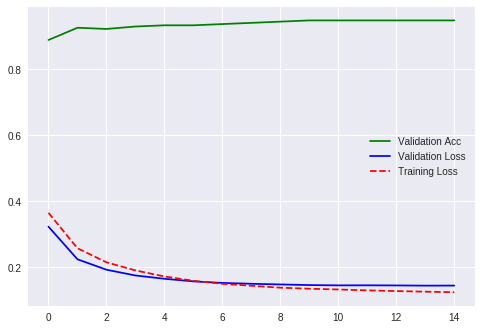

In [23]:
sns.set_style("darkgrid")
plt.plot(acc_plot,'g-',label="Validation Acc")
plt.plot(loss_plot, 'b-', label="Validation Loss")
plt.plot(train_plot, "r--", label='Training Loss')
plt.legend(loc='best')

In [13]:
images_feed, labels_feed = MNIST_DATASETS.validation.images, MNIST_DATASETS.validation.labels

feed_dict = {
    images_pl: np.reshape(images_feed, (-1, 28, 28, 1))
            }
with sess.as_default():
  accuracy  = sess.run([logits], feed_dict = feed_dict)
  
  preds = np.argmax(accuracy[0], 1)
  print(preds)

NameError: ignored

In [0]:
from sklearn.metrics import classification_report
print(classification_report(labels_feed, preds))

NameError: ignored

In [0]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(labels_feed, preds))

[[473   0   0   0   0   2   2   0   0   2]
 [  0 553   2   2   1   0   1   2   2   0]
 [  1  10 454   5   1   1   0   7   8   1]
 [  0   1   2 475   0   7   0   5   2   1]
 [  0   1   0   0 526   0   4   1   0   3]
 [  0   1   1   0   1 427   0   0   3   1]
 [  3   2   0   0   1   1 493   0   1   0]
 [  0   2   2   1   3   0   0 536   0   6]
 [  0   2   0   1   0   3   1   2 449   4]
 [  2   1   0   2   5   2   0   7   2 474]]


In [0]:
# graph = tf.GraphDef()
# graph.ParseFromString(tf_model.SerializeToString())

# with tf.Graph().as_default() as graph:
#         # The name var will prefix every op/nodes in your graph
#         # Since we load everything in a new graph, this is not needed
#     tf.import_graph_def(graph, name="prefix")
    
    